In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

data=pd.read_csv('../input/creditcard.csv')


# Any results you write to the current directory are saved as output.

In [8]:
data.describe()

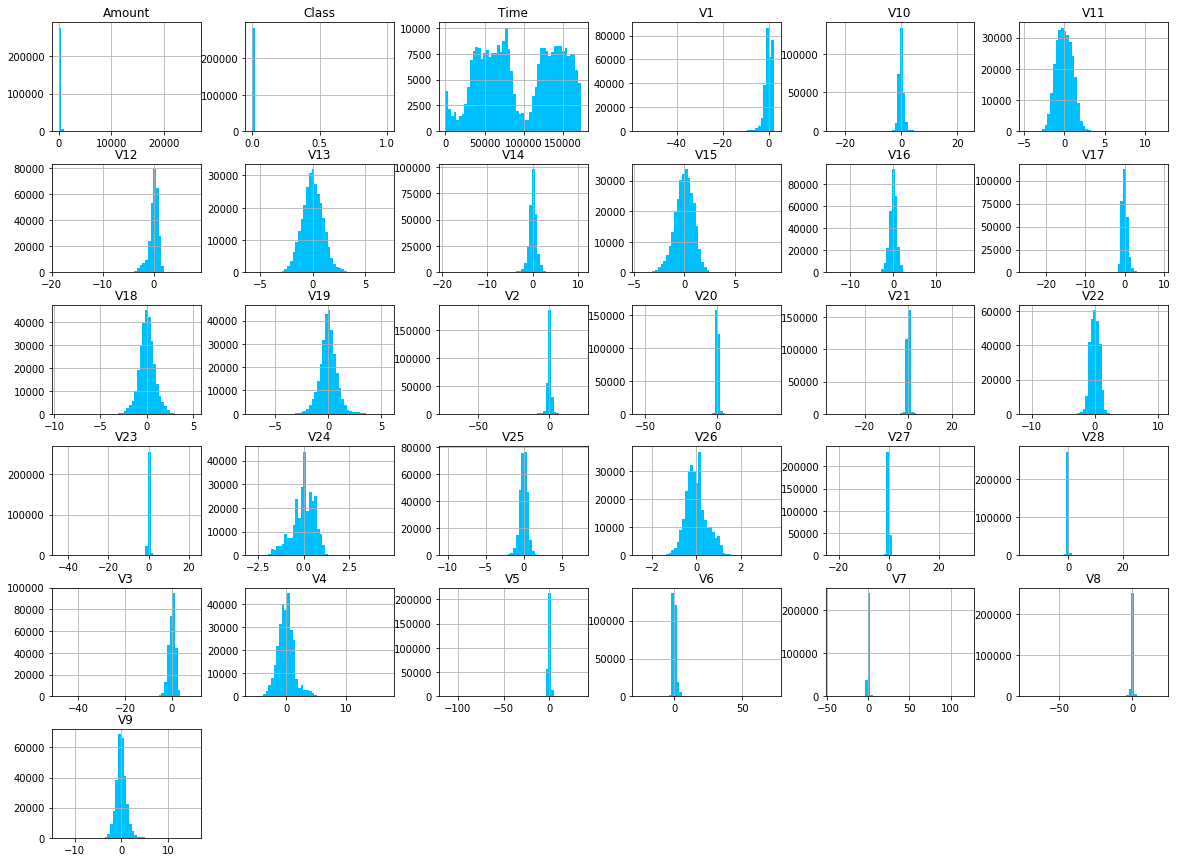

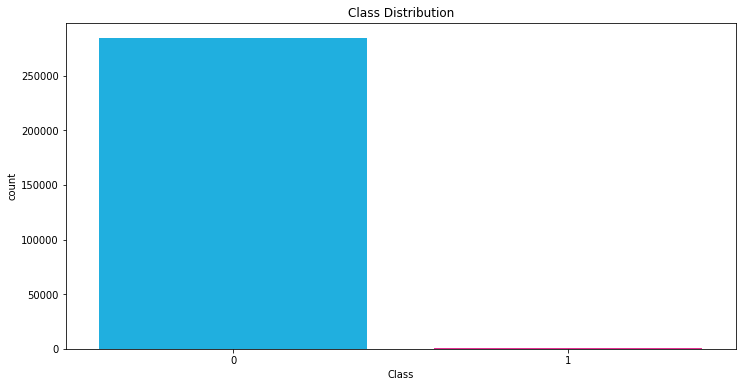

normal :  99.82725143693798 % and fraud:  0.1727485630620034 %


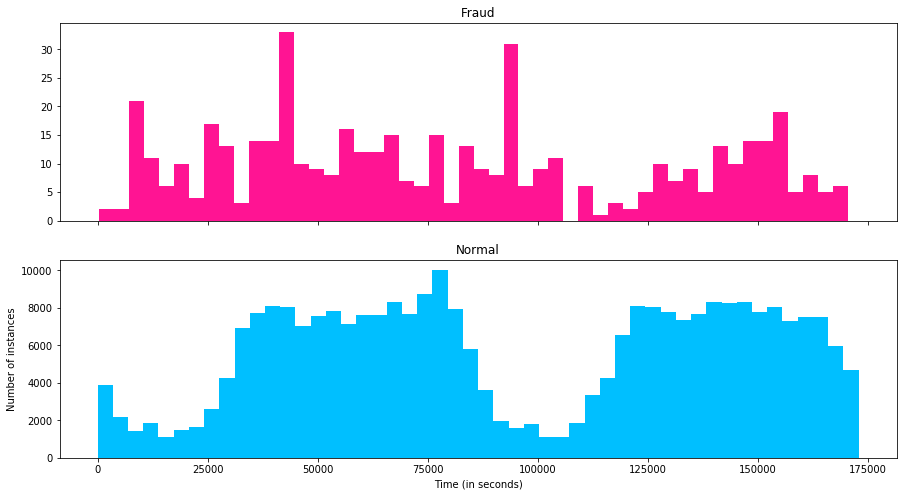

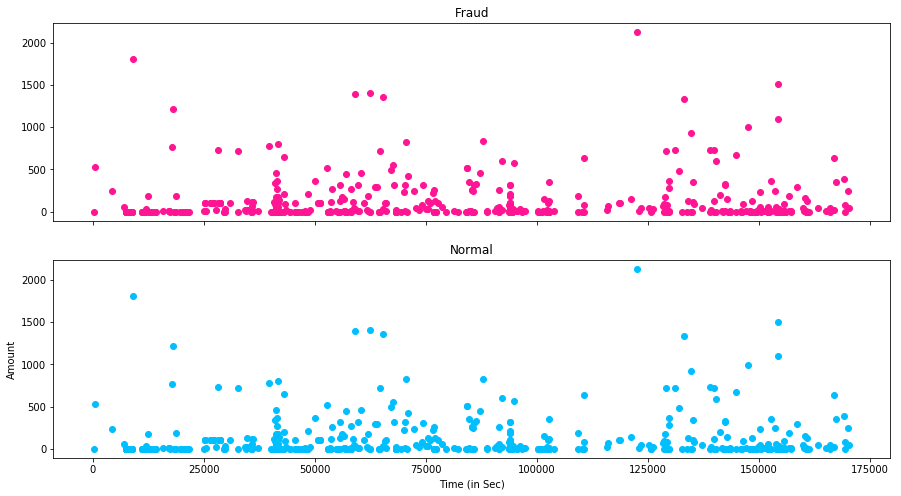

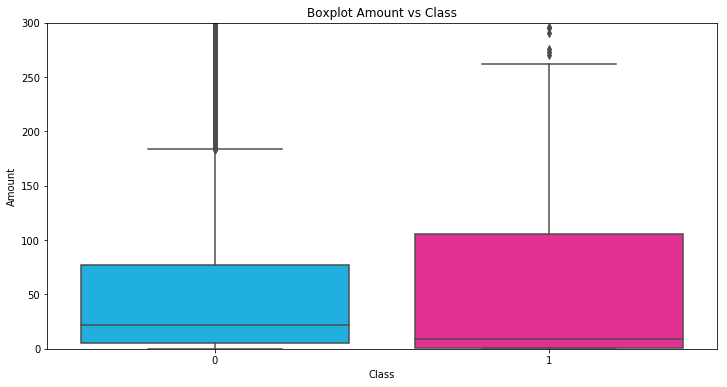

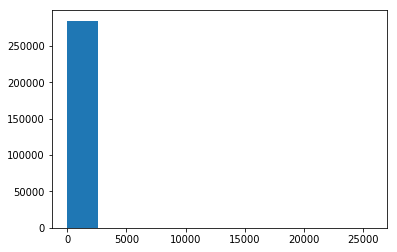

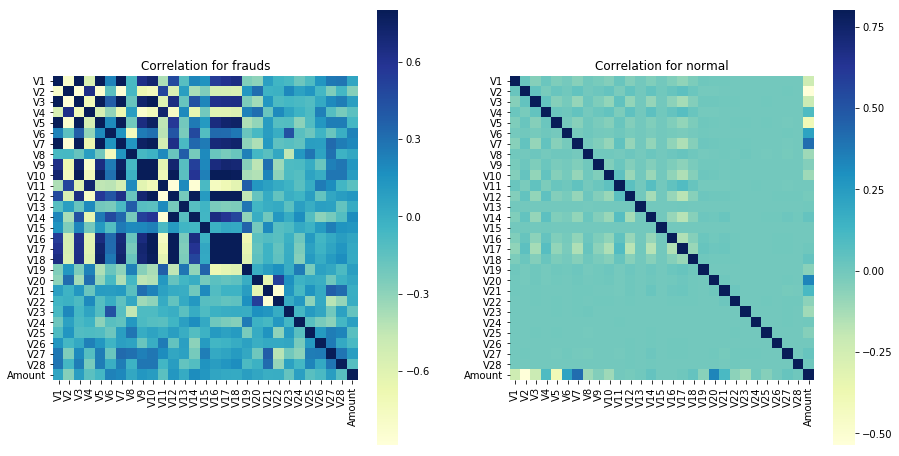

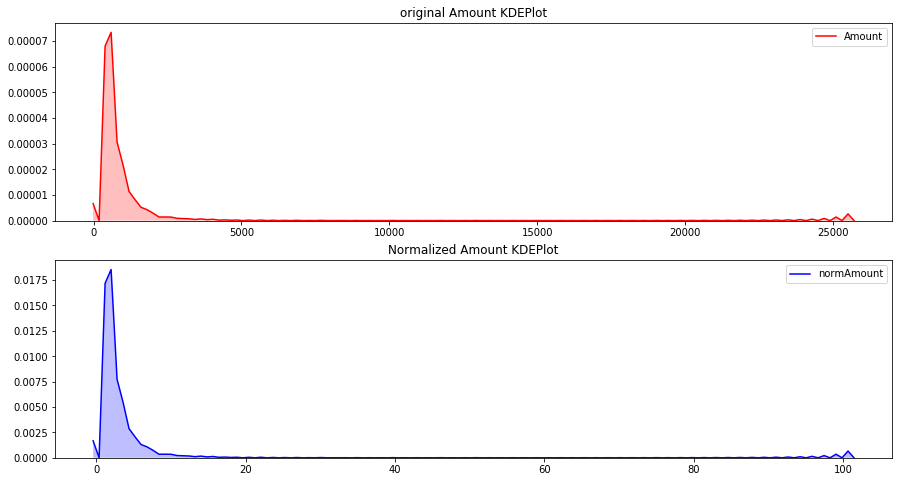

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:141: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


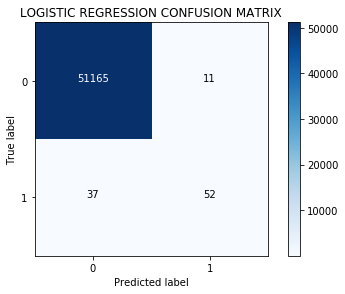

Precision: 0.825
Recall : 0.584
F1 Score: 0.684


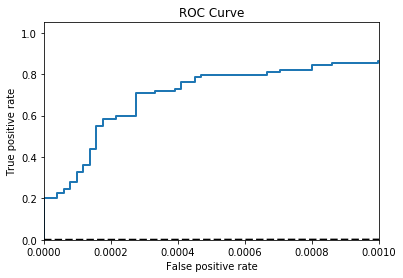

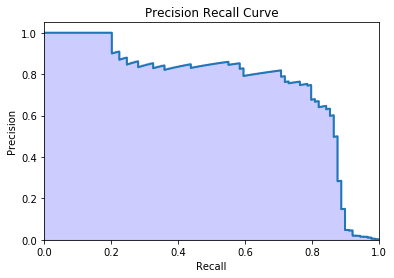

Parameters being used: 

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [3]:
data.hist(bins=50, figsize=(20,15), color='deepskyblue')
plt.show()
data.describe()
class_explore={0: 'deepskyblue', 1: 'deeppink'}

plt.figure(figsize=(12,6))
ax=sns.countplot(x='Class', data=data, palette=class_explore)
plt.title('Class Distribution')
plt.show()

#Counts
count_normal=len(data[data['Class']==0])
count_fraud=len(data[data['Class']==1])
percent_normal=count_normal/(len(data))*100
percent_fraud=count_fraud/(len(data))*100
print("normal : ",percent_normal,"% and fraud: ",percent_fraud,"%")

f, (ax1,ax2)=plt.subplots(2,1,sharex=True, figsize=(15,8))
bins=50
ax1.hist(data.Time[data.Class==1],bins=bins, color='deeppink')
ax1.set_title('Fraud')

ax2.hist(data.Time[data.Class==0], bins=bins, color='deepskyblue')
ax2.set_title('Normal')

plt.xlabel('Time (in seconds)')
plt.ylabel('Number of instances')
plt.show()

f, (ax1,ax2)=plt.subplots(2, 1, sharex=True, figsize=(15,8))
ax1.scatter(data.Time[data.Class==1], data.Amount[data.Class==1], color='deeppink')
ax1.set_title('Fraud')

ax2.scatter(data.Time[data.Class==1], data.Amount[data.Class==1], color='deepskyblue')
ax2.set_title('Normal')

plt.xlabel('Time (in Sec)')
plt.ylabel('Amount')

plt.show()

plt.figure(figsize=(12,6))
ax=sns.boxplot(x='Class' , y='Amount', data=data, palette=class_explore)
ax.set_ylim([0,300])
plt.title("Boxplot Amount vs Class")
plt.show()

plt.hist(data['Amount'])
plt.show()

f, (ax1,ax2)= plt.subplots(1,2, figsize=(15,8))
sns.heatmap(data.query('Class==1').drop(['Class','Time'],1).corr(),vmax=0.8, square=True, ax=ax1, cmap='YlGnBu')
ax1.set_title('Correlation for frauds')

sns.heatmap(data.query('Class==0').drop(['Class','Time'],1).corr(), vmax=0.8, square=True, ax=ax2, cmap='YlGnBu')
ax2.set_title('Correlation for normal')

plt.show()


#starting with ML

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    thresh=cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i, cm[i,j], horizontalalignment='center', color='white' if cm[i,j]>thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def show_metrics():
    tp=cm[1,1]
    fn=cm[1,0]
    fp=cm[0,1]
    tn=cm[0,0]
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    print('Precision: {:.3f}'.format(precision))
    print('Recall : {:.3f}'.format(recall))
    print('F1 Score: {:.3f}'.format((2*precision*recall)/(precision+recall)))
    
def plot_roc():
    plt.plot(fpr, tpr, label='ROC Curve', linewidth=2)
    plt.plot([0,1],[0,1],'k--',linewidth=2)
    plt.xlim([0.0,0.001])
    plt.ylim([0.0,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    plt.show()
    
def plot_precision_recall():
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();
    
    
    

from sklearn.model_selection import train_test_split
train_set, test_set=train_test_split(data, test_size=0.1, random_state=42)

data=train_set
valid_data=test_set

from sklearn.preprocessing import StandardScaler
data['normAmount']=StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

f, (ax1,ax2)= plt.subplots(2,1, figsize=(15,8))

sns.kdeplot(data['Amount'], shade=True, ax=ax1, color='red')
ax1.set_title('original Amount KDEPlot')

sns.kdeplot(data['normAmount'], shade=True, ax=ax2, color='blue')
ax2.set_title('Normalized Amount KDEPlot')

plt.show()

data=data.drop(['Amount','Time'], axis=1)
data.describe()


y=np.array(data.Class.tolist())
data=data.drop('Class',1)
X=np.array(data.as_matrix())

skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X,y):
    X_train, y_train= X[train_index], y[train_index]
    X_test, y_test= X[test_index], y[test_index]

log_clf=LogisticRegression()
log_clf.fit(X_train, y_train)
y_pred=log_clf.predict(X_test)
y_score=log_clf.decision_function(X_test)

cm=confusion_matrix(y_test, y_pred)
class_names=[0,1]
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='LOGISTIC REGRESSION CONFUSION MATRIX')
plt.show()
show_metrics()

fpr, tpr, t=roc_curve(y_test, y_score)
plot_roc()

precision, recall, thresholds=precision_recall_curve(y_test, y_score)
plot_precision_recall()

from pprint import pprint
print('Parameters being used: \n')
pprint(log_clf.get_params())





In [4]:
from sklearn.model_selection import GridSearchCV
param_grid={
    'penalty': ['l1','l2'],
    'class_weight':['balanced', None],
    'C': [0.1,1,10, 100]
}

CV_log_clf=GridSearchCV(estimator=log_clf, param_grid= param_grid, scoring= 'recall', verbose=1, n_jobs=-1)
CV_log_clf.fit(X_train, y_train)
best_params=CV_log_clf.best_params_
print('Best parameters: ',best_params)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  34 out of  48 | elapsed:  3.8min remaining:  1.6min
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:912: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:912: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  7.3min finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:718: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters:  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}


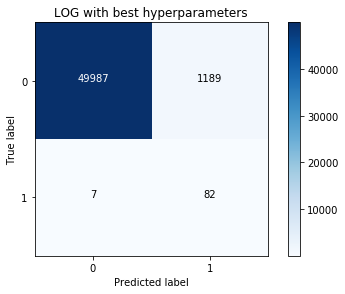

Precision: 0.065
Recall : 0.921
F1 Score: 0.121


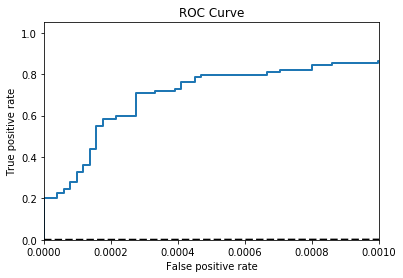

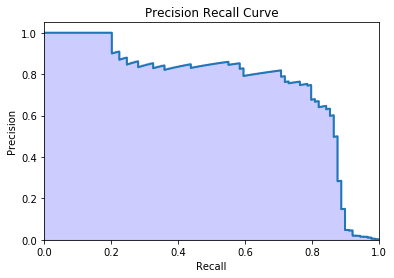

In [6]:
#logistic regression with best hyperparameters
log_clf=LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], class_weight=best_params['class_weight'])
log_clf.fit(X_train, y_train)
y_pred=log_clf.predict(X_test)
y_score=log_clf.decision_function(X_test)

#confusion matrix and metrics
cm=confusion_matrix(y_test, y_pred)
class_names=[0,1]
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='LOG with best hyperparameters')
plt.show()

show_metrics()

fpr_log, tpr_log, t_log= roc_curve(y_test, y_score)
plot_roc()

precision_log, recall_log, thresholds_log=precision_recall_curve(y_test, y_score)
plot_precision_recall()




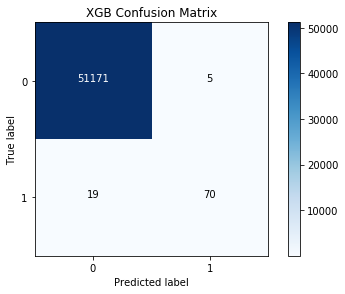

Precision: 0.933
Recall : 0.787
F1 Score: 0.854


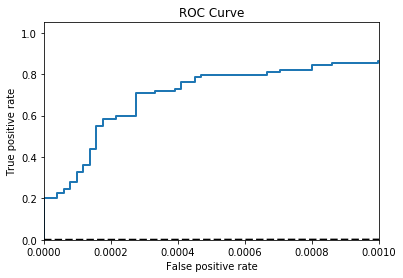

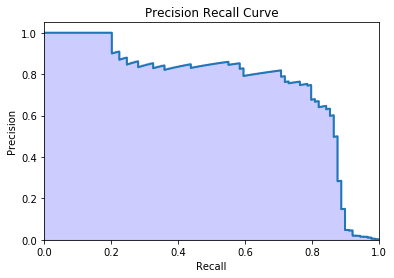

In [7]:
xgb_clf=xgb.XGBClassifier(n_jobs=-1)
xgb_clf.fit(X_train,y_train)
y_pred=xgb_clf.predict(X_test)
y_score=xgb_clf.predict_proba(X_test)[:,1]

cm=confusion_matrix(y_test, y_pred)
class_names=[0,1]
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='XGB Confusion Matrix')
plt.show()

show_metrics()

fpr_xgb, tpr_xgb, t_xgb=roc_curve(y_test, y_score)
plot_roc()

precision_xgb, recall_xgb, thresholds_xgb=precision_recall_curve(y_test, y_score)
plot_precision_recall()





In [11]:
param_grid={
    'n_estimators': [100, 200, 300, 400]
    
}


CV_xgb_clf=GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='f1', verbose=2)
eval_set=[(X_test,y_test)]
CV_xgb_clf.fit(X_train, y_train, early_stopping_rounds=10, eval_set=eval_set, verbose=True)

best_params_xgb=CV_xgb_clf.best_params_
print("Best parameters: ",best_params)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_estimators=100 ................................................
[0]	validation_0-error:0.000839
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.000741
[2]	validation_0-error:0.000683
[3]	validation_0-error:0.000683
[4]	validation_0-error:0.000663
[5]	validation_0-error:0.000702
[6]	validation_0-error:0.000683
[7]	validation_0-error:0.000702
[8]	validation_0-error:0.000702
[9]	validation_0-error:0.000683
[10]	validation_0-error:0.000702
[11]	validation_0-error:0.000702
[12]	validation_0-error:0.000683
[13]	validation_0-error:0.000683
[14]	validation_0-error:0.000683
Stopping. Best iteration:
[4]	validation_0-error:0.000663

[CV] ................................. n_estimators=100, total=   2.3s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[0]	validation_0-error:0.000858
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.000761
[2]	validation_0-error:0.000741
[3]	validation_0-error:0.00078
[4]	validation_0-error:0.000741
[5]	validation_0-error:0.000741
[6]	validation_0-error:0.000741
[7]	validation_0-error:0.000741
[8]	validation_0-error:0.000741
[9]	validation_0-error:0.000741
[10]	validation_0-error:0.000741
[11]	validation_0-error:0.000741
[12]	validation_0-error:0.000741
Stopping. Best iteration:
[2]	validation_0-error:0.000741

[CV] ................................. n_estimators=100, total=   2.1s
[CV] n_estimators=100 ................................................
[0]	validation_0-error:0.0008
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.0008
[2]	validation_0-error:0.0008
[3]	validation_0-error:0.0008
[4]	validation_0-error:0.0008
[5]	validation_0-error:0.00078
[6]	validation_0-error:0.000761
[7]	validation_0-error:0.000761
[8]	

[23]	validation_0-error:0.000683
[24]	validation_0-error:0.000663
[25]	validation_0-error:0.000663
[26]	validation_0-error:0.000663
[27]	validation_0-error:0.000663
[28]	validation_0-error:0.000663
[29]	validation_0-error:0.000663
[30]	validation_0-error:0.000663
[31]	validation_0-error:0.000663
[32]	validation_0-error:0.000644
[33]	validation_0-error:0.000663
[34]	validation_0-error:0.000663
[35]	validation_0-error:0.000624
[36]	validation_0-error:0.000624
[37]	validation_0-error:0.000644
[38]	validation_0-error:0.000624
[39]	validation_0-error:0.000624
[40]	validation_0-error:0.000527
[41]	validation_0-error:0.000527
[42]	validation_0-error:0.000527
[43]	validation_0-error:0.000527
[44]	validation_0-error:0.000527
[45]	validation_0-error:0.000527
[46]	validation_0-error:0.000527
[47]	validation_0-error:0.000527
[48]	validation_0-error:0.000527
[49]	validation_0-error:0.000527
[50]	validation_0-error:0.000527
Stopping. Best iteration:
[40]	validation_0-error:0.000527

[CV] ...........

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   51.2s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:718: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[0]	validation_0-error:0.000819
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.000761
[2]	validation_0-error:0.00078
[3]	validation_0-error:0.00078
[4]	validation_0-error:0.000761
[5]	validation_0-error:0.000761
[6]	validation_0-error:0.000761
[7]	validation_0-error:0.000741
[8]	validation_0-error:0.000741
[9]	validation_0-error:0.000741
[10]	validation_0-error:0.000741
[11]	validation_0-error:0.000722
[12]	validation_0-error:0.000722
[13]	validation_0-error:0.000741
[14]	validation_0-error:0.000741
[15]	validation_0-error:0.000741
[16]	validation_0-error:0.000702
[17]	validation_0-error:0.000702
[18]	validation_0-error:0.000702
[19]	validation_0-error:0.000702
[20]	validation_0-error:0.000683
[21]	validation_0-error:0.000683
[22]	validation_0-error:0.000683
[23]	validation_0-error:0.000702
[24]	validation_0-error:0.000702
[25]	validation_0-error:0.000702
[26]	validation_0-error:0.000683
[27]	validation_0-error:0.000683
[28]	validation_0-erro

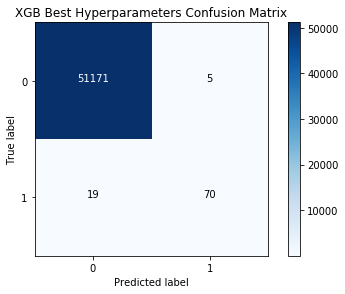

Precision: 0.933
Recall : 0.787
F1 Score: 0.854


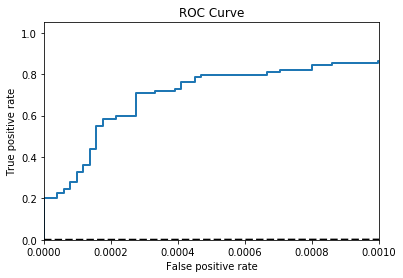

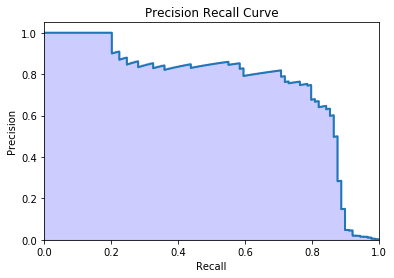

In [14]:
xgb_clf=xgb.XGBClassifier(n_estimators=best_params_xgb['n_estimators'],n_jobs=-1)
xgb_clf.fit(X_train, y_train)
y_pred=xgb_clf.predict(X_test)
y_score=xgb_clf.predict_proba(X_test)[:,1]

cm=confusion_matrix(y_test, y_pred)
class_names=[0,1]
plot_confusion_matrix(cm, classes=class_names, title='XGB Best Hyperparameters Confusion Matrix')
plt.show()
show_metrics()
fpr_xgb, tpr_xgb, t_xgb = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall curve
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_score)
plot_precision_recall()

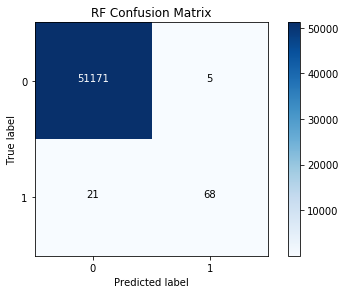

Precision: 0.932
Recall : 0.764
F1 Score: 0.840


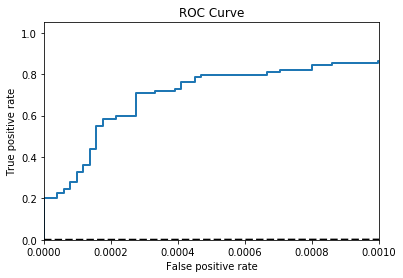

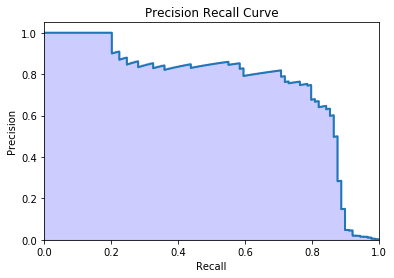

In [15]:
rf_clf=RandomForestClassifier(n_jobs=-1, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred=rf_clf.predict(X_test)
y_score=rf_clf.predict_proba(X_test)[:,1]

cm=confusion_matrix(y_test, y_pred)
class_names=[0,1]
plot_confusion_matrix(cm, classes=class_names, title='RF Confusion Matrix')
plt.show()
show_metrics()
fpr_rf, tpr_rf, t_rf = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall curve
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_score)
plot_precision_recall()

In [ ]:
param_grid = {
            'n_estimators': [100, 200, 500],
            'max_features': [2, 3],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10]
            }

CV_rnd_cfl = GridSearchCV(estimator = rf_clf, param_grid = param_grid, scoring = 'f1', verbose = 10, n_jobs = -1)
eval_set=[(X_test,y_test)]
CV_rnd_cfl.fit(X_train, y_train)

best_parameters = CV_rf_cfl.best_params_
print("The best parameters for using this model is", best_parameters)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


In [1]:
rf_cfl = RandomForestClassifier(n_estimators = best_parameters['n_estimators'], 
                                 max_features = best_parameters['max_features'], 
                                 min_samples_leaf = best_parameters['min_samples_leaf'], 
                                 min_samples_split = best_parameters['min_samples_split'], 
                                 n_jobs = -1,
                                random_state = 42)

rf_cfl.fit(X_train, y_train)
y_pred = rf_cfl.predict(X_test)
y_score = rf_cfl.predict_proba(X_test)[:,1]

# Confusion maxtrix
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names, 
                      title = 'RF Confusion matrix')
plt.show()

show_metrics()

# ROC curve
fpr_rf_best, tpr_rf_best, t_rf_best = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall curve
precision_rf_best, recall_rf_best, thresholds_rf_best = precision_recall_curve(y_test, y_score)
plot_precision_recall()

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
voting_clf=VotingClassifier(
estimators=[('xgb',xgb_clf),('lt',log_clf),('rf','rf_clf')],
voting= 'soft', weights=[1,1,1.33])
voting_clf.fit(X_train, y_train)
y_pred=voting_clf.predict(X_test)
y_score=voting_clf.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names, 
                      title = 'VOTING Confusion matrix')

plt.show()

show_metrics()

# ROC curve
fpr_voting, tpr_voting, t_voting = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall curve
precision_voting, recall_voting, thresholds_voting = precision_recall_curve(y_test, y_score)
plot_precision_recall()
